In [1]:
!pip install implicit -qqq
!pip install catboost -qqq

In [2]:
!ls /kaggle/input/kion-data/

interactions_df.csv  items.csv	users.csv


# Двухэтапная модель

## <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#232834"><b><span style='color:#686dec'>1 |</span></b> <b>Введение</b></div>

In [3]:
import datetime
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import scipy.sparse as sparse

from catboost import CatBoostClassifier
import implicit

import warnings
warnings.simplefilter('ignore')

## <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#232834"><b><span style='color:#686dec'>2 |</span></b> <b>Датасет КИОН</b></div>

- просмотры фильмов и сериалов в приложении KION
- данные о пользователях
- данные об айтемах (фильмы, сериалы и т.д.)

In [4]:
interactions = pd.read_csv("/kaggle/input/kion-data/interactions_df.csv")
items = pd.read_csv("/kaggle/input/kion-data/items.csv")
users = pd.read_csv("/kaggle/input/kion-data/users.csv")

### <b><span style='color:#686dec'>Данные о взаимодействий пользователях с фильмами </span></b>

Как и ранше у нас стандартые фичи
- `user_id` : пользователь
- `item_id` : фильм 

У нас есть фича времени последнего запуска фильма 

- `last_watch_dt` дата просмотра

И фичи взаимодействий:

- `total_dur` длительность просмотра
- `watched_pct` доля просмотра в %

In [5]:
# деятельность пользователей 
interactions.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [6]:
# change the string to date
interactions['last_watch_dt'] = interactions['last_watch_dt'].astype('datetime64[ns]').dt.date 

In [7]:
# check the unique number of films and users
print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique()}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique()}")

Уникальных юзеров в interactions: 962179
Уникальных айтемов в interactions: 15706


In [8]:
# check the all user activity limits
max_date = interactions['last_watch_dt'].max()
min_date = interactions['last_watch_dt'].min()

print(f"min дата в interactions: {min_date}")
print(f"max дата в interactions: {max_date}")

min дата в interactions: 2021-03-13
max дата в interactions: 2021-08-22



### <b><span style='color:#686dec'>Данные о пользователях</span></b>

Все признаки - результат предсказания соцдем моделей

- `age` : Возростная группа 
- `income` : Группа дохода пользователя 
- `sex` : Пол пользователя
- `kids_flg` : флаг наличия детей


In [9]:
users.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [10]:
# number of unique users in database
f"Уникальных юзеров в users: {users.shape[0]}"

'Уникальных юзеров в users: 840197'

### <b><span style='color:#686dec'>Данные о товарах
</span></b>

- `content_type` - тип контента
- `title` - название на русском
- `title_orig` - название оригинальное
- `release_year` - год выпуска
- `countries` - страны
- `for_kids` - флаг контент для детей
- `age_rating`- Возрастной рейтинг
- `studios` - студии
- `directors` - режиссеры
- `actors`- актеры
- `keywords` - ключевые слова
- `description` - описание

In [11]:
items.head(3)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."


In [12]:
f"Уникальных айтемов в items {items.shape[0]}"

'Уникальных айтемов в items 15963'

## <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#232834"><b><span style='color:#686dec'>3 |</span></b> <b>Разбиение на Подвыборки</b></div>

### <b><span style='color:#686dec'>Обучающая выборка</span></b>

Для двухуровних моделях есть нюанс при разбиение на подвыборки 
- Модель первого уровня нужна для предварительного отбора кандидатов 

### <b><span style='color:#686dec'>Тестовая выборка</span></b>

На `test` будем проверять результат обоих моделей:
-  отдельно модели первого уровня
- отдельно двухуровненой модели

На test оставим 7 дней


In [13]:
# фильтрация для исключения случайных просмотров
interactions = interactions[interactions['total_dur'] >= 300]

In [14]:
user_interactions_count = interactions.groupby('user_id')[['item_id']].count().reset_index()

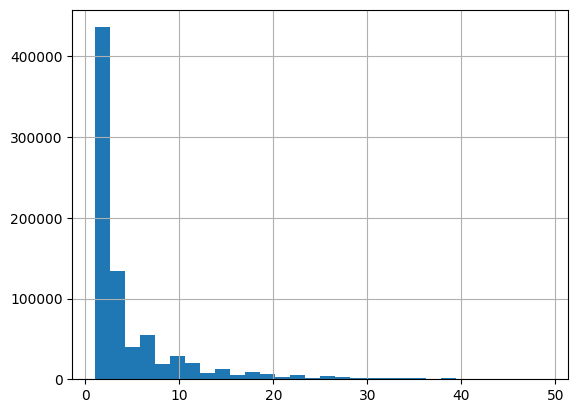

In [15]:
user_interactions_count[user_interactions_count['item_id'] < 50]['item_id'].hist(bins=30)
plt.show()

In [16]:
sum(user_interactions_count['item_id'] < 10) / user_interactions_count.shape[0]

0.8652543241717588

In [17]:
filtered_users = user_interactions_count[user_interactions_count['item_id'] >= 10][['user_id']]
interactions = filtered_users.merge(interactions, how='left')

In [18]:
# Просмотров для каждого фильа
item_interactions_count = interactions.groupby('item_id')[['user_id']].count().reset_index()

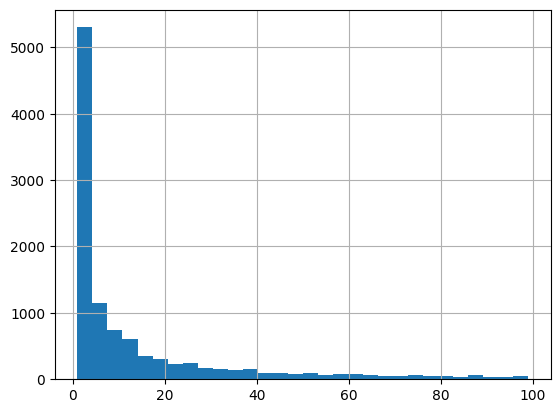

In [19]:
item_interactions_count[item_interactions_count['user_id'] < 100]['user_id'].hist(bins=30)
plt.show()

In [20]:
# Пропорция фильмой у которых меньше 10 просмотров
sum(item_interactions_count['user_id'] < 10) / item_interactions_count.shape[0]

0.5165371809100999

In [21]:
# Фильтруем пользователей у которых 
filtered_items = item_interactions_count[item_interactions_count['user_id'] >= 10][['item_id']]
interactions = filtered_items.merge(interactions, how='left')

In [22]:
interactions.shape

(2300516, 5)

In [23]:
test_threshold = max_date - pd.Timedelta(days=7)
val_threshold = test_threshold - pd.Timedelta(days=60) 

# два месяца для обучения модели второго уровня
test = interactions[(interactions['last_watch_dt'] >= test_threshold)]
train_val = interactions[(interactions['last_watch_dt'] < test_threshold)]

val = train_val[(train_val['last_watch_dt'] >= val_threshold)]
train = train_val[(train_val['last_watch_dt'] < val_threshold)]

print(f"train: {train.shape}")
print(f"val: {val.shape}")
print(f"test: {test.shape}")

train: (881660, 5)
val: (1246263, 5)
test: (172593, 5)


## <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#232834"><b><span style='color:#686dec'>5 |</span></b> <b>1 ЭТАП: Модель Первого Уровня</b></div>

- Обучаем `bpr` модель из библиотеки `implicit` на `train`
- Делаем предикт c кандидатами на `val` (валидационная выборка)
- Будем предсказывать кандидатов только на теплых пользователях - у которых есть просмотры в обучающей выборке

In [24]:
val = val[val['user_id'].isin(train['user_id'].unique())]

In [25]:
val.head()

,item_id,user_id,last_watch_dt,total_dur,watched_pct
1,0,184560,2021-07-18,13278,50.0
3,0,379871,2021-07-04,4279,3.0
5,0,427911,2021-08-11,5363,38.0
7,0,573405,2021-08-01,10164,9.0
15,0,968581,2021-08-04,7310,6.0


In [26]:
users_id = list(np.sort(train.user_id.unique()))
items_train = list(train.item_id.unique())
ratings_train = list(train.watched_pct)

rows_train = train.user_id.astype('category').cat.codes
cols_train = train.item_id.astype('category').cat.codes

train_sparse = sparse.csr_matrix((ratings_train, (rows_train, cols_train)), shape=(len(users_id), len(items_train)))

In [27]:
matrix_size = train_sparse.shape[0] * train_sparse.shape[1] # Number of possible interactions in the matrix
num_interactions = len(train_sparse.nonzero()[0]) # Number of items interacted with
sparsity = 100 * (1 - (num_interactions / matrix_size))
sparsity

99.79592704093007

In [28]:
train_sparse

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 881660 stored elements and shape (72354, 5860)>

In [29]:
algo = implicit.bpr.BayesianPersonalizedRanking(factors=50, regularization=0.01,
    iterations=50, 
    use_gpu=False)
algo.fit((train_sparse).astype('double'))

  0%|          | 0/50 [00:00<?, ?it/s]

In [30]:
# матрицы для пользователей и предметов из матричной факторизации
user_vecs = algo.user_factors
item_vecs = algo.item_factors

In [31]:
# top N фильмов
k = 30

In [32]:
# Делаем рекомендации [implicit]
def predict(user_vecs, item_vecs, k=10):
    
    id2user = dict(zip(rows_train, train.user_id))
    id2item = dict(zip(cols_train, train.item_id))

    scores = user_vecs.dot(item_vecs.T)

    ind_part = np.argpartition(scores, -k + 1)[:, -k:].copy()
    scores_not_sorted = np.take_along_axis(scores, ind_part, axis=1)
    ind_sorted = np.argsort(scores_not_sorted, axis=1)
    indices = np.take_along_axis(ind_part, ind_sorted, axis=1)
    indices = np.flip(indices, 1)
    preds = pd.DataFrame({
        'user_id': range(user_vecs.shape[0]),
        'preds': indices.tolist(),
        })
    preds['user_id'] = preds['user_id'].map(id2user)
    preds['preds'] = preds['preds'].map(lambda inds: [id2item[i] for i in inds])
    return preds

In [33]:
val_user_history = val.groupby('user_id')[['item_id']].agg(lambda x: list(x))
pred_bpr = predict(user_vecs, item_vecs, k)
pred_bpr = val_user_history.merge(pred_bpr, how='left', on='user_id')

In [34]:
pred_bpr.head()

,user_id,item_id,preds
0,2,"[242, 3628, 5819, 7106, 7921, 8482, 9164, 1077...","[3166, 8482, 12965, 4072, 11749, 1267, 16382, ..."
1,21,"[308, 3784, 4495, 5077, 6384, 7102, 7571, 8251...","[849, 11237, 24, 1053, 7713, 13936, 7417, 8524..."
2,30,"[1107, 2346, 2743, 3031, 7250, 9728, 9842, 112...","[13865, 4740, 10464, 142, 16201, 3017, 12396, ..."
3,46,[10440],"[4880, 142, 4151, 9996, 8636, 13865, 1465, 474..."
4,60,"[1179, 1343, 1590, 3550, 6044, 6606, 8612, 972...","[4880, 13865, 4151, 2657, 1083, 1449, 7107, 29..."


In [35]:
def recall(df: pd.DataFrame, 
           pred_col='preds', 
           true_col='item_id', 
           k=30) -> float:
    
    recall_values = []
    for _, row in df.iterrows():
      num_relevant = len(set(row[true_col]) & set(row[pred_col][:k]))
      num_true = len(row[true_col])
      recall_values.append(num_relevant / num_true)
    return np.mean(recall_values)

In [36]:
def precision(df: pd.DataFrame, 
              pred_col='preds', 
              true_col='item_id',
              k=30) -> float:
    
    precision_values = []
    for _, row in df.iterrows():
      num_relevant = len(set(row[true_col]) & set(row[pred_col][:k]))
      num_true = min(k, len(row[true_col]))
      precision_values.append(num_relevant / num_true)
    return np.mean(precision_values)

In [37]:
def mrr(df: pd.DataFrame, 
        pred_col='preds', 
        true_col='item_id', 
        k=30) -> float:
    
    mrr_values = []
    for _, row in df.iterrows():
      intersection = set(row[true_col]) & set(row[pred_col][:k])
      user_mrr = 0
      if len(intersection) > 0:
          for item in intersection:
              user_mrr = max(user_mrr, 1 / (row[pred_col].index(item) + 1))
      mrr_values.append(user_mrr)
    return np.mean(mrr_values)

In [38]:
recall(pred_bpr)

0.10971724310666944

In [39]:
precision(pred_bpr)

0.1108938431397026

In [40]:
mrr(pred_bpr)

0.12739334967701704

In [41]:
# генерируем предказания
candidates = pred_bpr[['user_id', 'preds']]
candidates = candidates.explode('preds').rename(columns={'preds': 'item_id'})
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1

candidates.head()

,user_id,item_id,rank
0,2,3166,1
0,2,8482,2
0,2,12965,3
0,2,4072,4
0,2,11749,5


## <div style="padding: 30px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#232834"><b><span style='color:#686dec'>6 |</span></b> <b>2 ЭТАП: Обучаем Бустинг</b></div>

- Ставим задачу как бинарную классификацию
- Выбираем `CatBoostClassifier`, так как много категориальных признаков

###  Собираем train + target

`target = 1` Позитивные взаимодействия = все что пользователь посмотрел из кандидатов bpr

In [42]:
pos = candidates.merge(val,
                       on=['user_id', 'item_id'],
                       how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(60919, 7)


,user_id,item_id,rank,last_watch_dt,total_dur,watched_pct,target
0,2,8482,2,2021-06-18,5886,100.0,1
1,2,9164,9,2021-06-23,6650,100.0,1
2,46,10440,13,2021-07-05,7449,20.0,1
3,60,15297,25,2021-07-24,14896,88.0,1
4,81,9996,7,2021-06-19,2939,10.0,1


`target = 0` Негативные взаимодействия = все что пользователь НЕ посмотрел из кандидатов bpr

- добавим сэмплирование, чтобы соблюсти баланс классов

In [43]:
neg = candidates.set_index(['user_id', 'item_id'])\
        .join(val.set_index(['user_id', 'item_id']))

neg = neg[neg['watched_pct'].isnull()].reset_index()

## Формируем трейн и тест: ctb_train, ctb_test

### Важно! Делим по пользователям, а не по дате.

`Мотивация`:

- Для негативных взаимодействий нет даты
- Проверяем устойчивость бустинга относительно новых (холодных) пользователей

In [44]:
pos.shape[0] / neg.shape[0]

0.03351468161905197

In [45]:
# пусть негативных семплов будет в два раза больше, чем позитивных
neg = neg.sample(frac=0.07)
neg['target'] = 0

neg.shape

(127238, 7)

In [46]:
ctb_train_users, ctb_test_users = train_test_split(val['user_id'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

In [47]:
# выделяем 10% под механизм early stopping
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

In [48]:
select_col = ['user_id', 'item_id', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
])[select_col]
)

# for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
])[select_col]
)

### Проверяем баланс классов

In [49]:
ctb_train['target'].value_counts(normalize=True)

target
0    0.676539
1    0.323461
Name: proportion, dtype: float64

In [50]:
ctb_test['target'].value_counts(normalize=True)

target
0    0.675174
1    0.324826
Name: proportion, dtype: float64

## Формируем фичи

- в этом ноутбуке рассмотрен бейзлайн с минимальной обработкой признаков - оставляем ее для Catboost
- выбираем простые категориальные признаки, которые не нужно предобрабатывать
- как признак также используем `rank` от модели 1 этапа
- заполняем пропуски в данных

In [51]:
user_col = ['user_id', 'age', 'income', 'sex', 'kids_flg']
item_col = ['item_id', 'content_type', 'countries', 'for_kids', 'age_rating', 'studios']

In [52]:
train_feat = (ctb_train
              .merge(users[user_col], on=['user_id'], how='left')
              .merge(items[item_col], on=['item_id'], how='left'))

eval_feat = (ctb_eval
             .merge(users[user_col], on=['user_id'], how='left')
             .merge(items[item_col], on=['item_id'], how='left'))

In [53]:
train_feat.head()

,user_id,item_id,rank,target,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,458479,12485,23,0,age_55_64,income_20_40,М,0.0,film,США,NaN,18.0,NaN
1,4176,4880,1,0,age_35_44,income_0_20,Ж,0.0,series,Россия,NaN,18.0,NaN
2,1055166,5087,22,0,age_25_34,income_40_60,М,1.0,film,США,NaN,18.0,NaN
3,800395,2860,18,0,NaN,NaN,NaN,NaN,film,Канада,NaN,16.0,NaN
4,637341,509,30,0,age_25_34,income_0_20,Ж,1.0,film,Россия,0.0,18.0,NaN


### X,y

In [54]:
drop_col = ['user_id', 'item_id']
target_col = ['target']
cat_col = ['age', 'income', 'sex', 'content_type', 'countries', 'studios']

In [55]:
X_train, y_train = train_feat.drop(drop_col + target_col, axis=1), train_feat[target_col]
X_val, y_val = eval_feat.drop(drop_col + target_col, axis=1), eval_feat[target_col]

In [56]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((135296, 10), (135296, 1), (15090, 10), (15090, 1))

In [57]:
# fillna for catboost with the most frequent value
X_train = X_train.fillna(X_train.mode().iloc[0])

In [58]:
# fillna for catboost with the most frequent value
X_val = X_val.fillna(X_train.mode().iloc[0])

In [59]:
X_train.head()

,rank,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,23,age_55_64,income_20_40,М,0.0,film,США,0.0,18.0,CBS All Access
1,1,age_35_44,income_0_20,Ж,0.0,series,Россия,0.0,18.0,CBS All Access
2,22,age_25_34,income_40_60,М,1.0,film,США,0.0,18.0,CBS All Access
3,18,age_35_44,income_20_40,М,0.0,film,Канада,0.0,16.0,CBS All Access
4,30,age_25_34,income_0_20,Ж,1.0,film,Россия,0.0,18.0,CBS All Access


## Обучаем `CatBoostClassifier`

- аналогично 1 этапу, предполагаем что оптимальные гиперпараметры уже выбраны
- используем только механизм early_stopping для выбора оптимального количества деревьев на небольшой валидационной выборке

In [60]:
# параметры для обучения
est_params = {
  'subsample': 0.9,
  'max_depth': 5,
  'n_estimators': 2000,
  'learning_rate': 0.01,
  'thread_count': 20,
  'random_state': 42,
  'verbose': 200,
}

ctb_model = CatBoostClassifier(**est_params)

In [61]:
ctb_model.fit(X_train,
              y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=100,
              cat_features=cat_col)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TBB Warning: The number of workers is currently limited to 3. The request for 19 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 0.6900380	test: 0.6900920	best: 0.6900920 (0)	total: 175ms	remaining: 5m 50s
200:	learn: 0.5295179	test: 0.5325592	best: 0.5325592 (200)	total: 17.5s	remaining: 2m 36s
400:	learn: 0.5210290	test: 0.5236199	best: 0.5236199 (400)	total: 34.4s	remaining: 2m 17s
600:	learn: 0.5187233	test: 0.5211758	best: 0.5211758 (600)	total: 51.9s	remaining: 2m
800:	learn: 0.5173139	test: 0.5197243	best: 0.5197243 (800)	total: 1m 8s	remaining: 1m 43s
1000:	learn: 0.5160030	test: 0.5183970	best: 0.5183970 (1000)	total: 1m 26s	remaining: 1m 26s
1200:	learn: 0.5148874	test: 0.5173102	best: 0.5173096 (1198)	total: 1m 43s	remaining: 1m 9s
1400:	learn: 0.5139265	test: 0.5164289	best: 0.5164289 (1400)	total: 2m 1s	remaining: 52s
1600:	learn: 0.5133713	test: 0.5159957	best: 0.5159953 (1598)	total: 2m 18s	remaining: 34.6s
1800:	learn: 0.5127885	test: 0.5155605	best: 0.5155605 (1800)	total: 2m 36s	remaining: 17.3s
1999:	learn: 0.5123560	test: 0.5152680	best: 0.5152680 (1999)	total: 2m 54s	remaining: 0us

## Посмотрим на feature importance

In [62]:
imp_catboost = pd.DataFrame(X_train.columns, columns = ['feature'])
imp_catboost['importance'] = ctb_model.feature_importances_

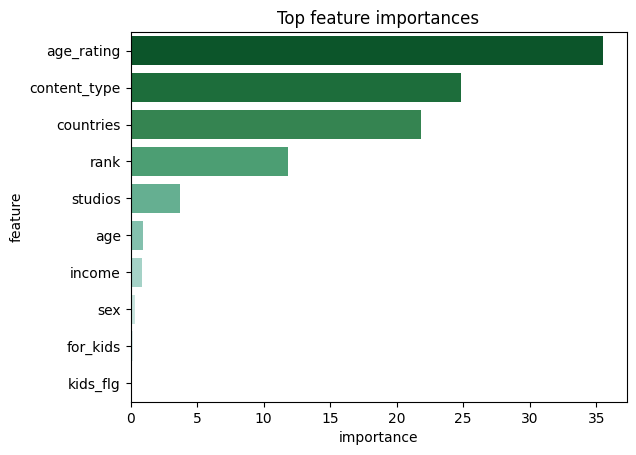

In [63]:
sns.barplot(data=imp_catboost.sort_values(by='importance', ascending=False), x='importance', y='feature', palette="BuGn_r")
plt.title('Top feature importances');

## Оценим метрики catboost модели

In [64]:
test_feat = (ctb_test
             .merge(users[user_col], on=['user_id'], how='left')
             .merge(items[item_col], on=['item_id'], how='left'))

In [65]:
# fillna for catboost with the most frequent value
test_feat = test_feat.fillna(X_train.mode().iloc[0])

In [66]:
X_test, y_test = test_feat.drop(drop_col + target_col, axis=1), test_feat['target']

In [67]:
X_test.head()

,rank,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,2,age_35_44,income_20_40,М,1.0,film,Канада,0.0,18.0,CBS All Access
1,7,age_35_44,income_20_40,М,0.0,film,"США, Великобритания, Франция",0.0,16.0,CBS All Access
2,29,age_45_54,income_40_60,М,1.0,film,Россия,0.0,18.0,CBS All Access
3,6,age_18_24,income_40_60,М,0.0,film,Россия,0.0,16.0,CBS All Access
4,7,age_18_24,income_20_40,Ж,0.0,film,США,0.0,12.0,CBS All Access


In [68]:
y_pred = ctb_model.predict_proba(X_test)

In [69]:
f"ROC AUC score = {roc_auc_score(y_test, y_pred[:, 1]):.2f}"

'ROC AUC score = 0.77'

# Метрики качества на глобальном test

- Формируем рекомендации отдельно моделью 1 этапа - bpr
- Отдельно двухэтапной моделью bpr + Catboost
- Сравниваем

## 1) Метрики качества bpr

In [70]:
# оставляем только теплых пользователей
test = test[test['user_id'].isin(val['user_id'].unique())]

In [71]:
test_user_history = test.groupby('user_id')[['item_id']].agg(lambda x: list(x))
pred_bpr = predict(user_vecs, item_vecs, k=100)
pred_bpr = test_user_history.merge(pred_bpr, how='left', on='user_id')

In [72]:
recall(pred_bpr, k=20)

0.042217550721510705

In [73]:
precision(pred_bpr, k=20)

0.04225740023000195

In [74]:
mrr(pred_bpr, k=20)

0.021039760800473414

## 2) Метрики качества двухэтапной модели: `bpr` + `Catboost`

In [75]:
# генерируем предказания

pred_bpr = pred_bpr[['user_id', 'preds']]
pred_bpr = pred_bpr.explode('preds').rename(columns={'preds': 'item_id'})
pred_bpr['rank'] = pred_bpr.groupby('user_id').cumcount() + 1

pred_bpr.head()

,user_id,item_id,rank
0,21,849,1
0,21,11237,2
0,21,24,3
0,21,1053,4
0,21,7713,5


In [76]:
pred_bpr_ctb = pred_bpr.copy()

# фичи для теста
score_feat = (pred_bpr_ctb
              .merge(users[user_col], on=['user_id'], how='left')
              .merge(items[item_col], on=['item_id'], how='left'))

# fillna for catboost with the most frequent value
score_feat = score_feat.fillna(X_train.mode().iloc[0])

In [77]:
score_feat.head()

,user_id,item_id,rank,age,income,sex,kids_flg,content_type,countries,for_kids,age_rating,studios
0,21,849,1,age_45_54,income_20_40,Ж,0.0,film,США,0.0,18.0,CBS All Access
1,21,11237,2,age_45_54,income_20_40,Ж,0.0,film,Россия,0.0,16.0,CBS All Access
2,21,24,3,age_45_54,income_20_40,Ж,0.0,series,Германия,0.0,16.0,CBS All Access
3,21,1053,4,age_45_54,income_20_40,Ж,0.0,film,США,0.0,18.0,CBS All Access
4,21,7713,5,age_45_54,income_20_40,Ж,0.0,film,Россия,0.0,16.0,CBS All Access


In [78]:
# catboost predict_proba
ctb_prediction = ctb_model.predict_proba(score_feat.drop(drop_col, axis=1, errors='ignore'))

pred_bpr_ctb['ctb_pred'] = ctb_prediction[:, 1]
pred_bpr_ctb.head(3)

,user_id,item_id,rank,ctb_pred
0,21,849,1,0.238199
0,21,11237,2,0.423691
0,21,24,3,0.182443


### Проставляем итоговый ранк двухэтапной модели

In [79]:
# сортируем по скору внутри одного пользователя и проставляем новый ранг
pred_bpr_ctb = pred_bpr_ctb.sort_values(
    by=['user_id', 'ctb_pred'], ascending=[True, False])
pred_bpr_ctb['rank_ctb'] = pred_bpr_ctb.groupby('user_id').cumcount() + 1

In [80]:
pred_bpr_ctb.head(10)

,user_id,item_id,rank,ctb_pred,rank_ctb
0,21,4880,38,0.739261,1
0,21,13936,6,0.515807,2
0,21,7713,5,0.442528,3
0,21,11237,2,0.423691,4
0,21,7417,7,0.380741,5
0,21,12058,9,0.307638,6
0,21,496,10,0.290765,7
0,21,12701,45,0.269757,8
0,21,8252,67,0.269757,9
0,21,8636,11,0.258652,10


### `1+2 этапы bpr + Сatboost`: Метрики

In [81]:
true_items = test.groupby('user_id').agg(lambda x: list(x))[['item_id']].reset_index()
pred_items = pred_bpr_ctb.groupby('user_id').agg(lambda x: list(x))[['item_id']].reset_index().rename(columns={'item_id': 'preds'})
true_pred_items = true_items.merge(pred_items, how='left')

In [82]:
recall(true_pred_items, k=20)

0.05371511488902361

In [83]:
precision(true_pred_items, k=20)

0.0537566192633558

In [84]:
mrr(true_pred_items, k=20)

0.03348700850344106